In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, brier_score_loss, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import optuna

In [4]:
import warnings
from sklearn.exceptions import DataConversionWarning

In [5]:
os.chdir(r'C:\Users\decmg\OneDrive\Documentos\Material Disciplinas\MO436-IA Ética\Atividade 2')

## Importação Dos Dados

In [6]:
x_train,x_val,y_train,y_val = pd.read_csv('X_train.csv'),pd.read_csv('X_val.csv'),pd.read_csv('y_train.csv'),pd.read_csv('y_val.csv')

In [7]:
y_train.drop(['Unnamed: 0'],axis=1,inplace=True),
y_val.drop(['Unnamed: 0'],axis=1,inplace=True)
x_train.drop(['Unnamed: 0'],axis=1,inplace=True)
x_val.drop(['Unnamed: 0'],axis=1,inplace=True)

## Definindo Funções

In [8]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score, log_loss, brier_score_loss, roc_auc_score
def calculate_metrics(X_train, X_val, y_train, y_val, models, threshold=0.5):
    results = []
    predictions = {}
    
    # Lista de Models
    for model_name, model in models.items():
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict proba sobre a validaçào
        y_pred_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None
        
        if y_pred_proba is not None:
            y_pred = (y_pred_proba >= threshold).astype(int)
        else:
            y_pred = model.predict(X_val)
        
        # Salvar Predicoes
        predictions[f"y_pred_{model_name}"] = y_pred
        
        # Setar Métricas
        metrics = {
            "Model": model_name,
            "Accuracy": accuracy_score(y_val, y_pred),
            "Balanced Accuracy": balanced_accuracy_score(y_val, y_pred),
            "Recall": recall_score(y_val, y_pred),
            "Precision": precision_score(y_val, y_pred),
            "F1 Score": f1_score(y_val, y_pred),
            "Risk Bayes (Log Loss)": log_loss(y_val, y_pred_proba) if y_pred_proba is not None else "N/A",
            "Brier Score": brier_score_loss(y_val, y_pred_proba) if y_pred_proba is not None else "N/A",
            "AUC": roc_auc_score(y_val, y_pred_proba) if y_pred_proba is not None else "N/A"
        }
        
        results.append(metrics)
    metrics_df = pd.DataFrame(results)
    display(metrics_df)
    return metrics_df, predictions


In [9]:
## Definição do Melhor Threshold a Partir dos Dados
def bayesian_threshold(p_class1, p_class0, cost_fp, cost_fn):
    return (p_class1 * cost_fp) / (p_class0 * cost_fn)

total_samples = len(y_train)

p_class1 = np.sum(y_train == 1) / total_samples  # Proporção da Classe 1
p_class0 = np.sum(y_train == 0) / total_samples  # Proporção da Classe 0
cost_fp = 10 # Custo de um falso positivo
cost_fn = 100   # Custo de um falso negativo

threshold = bayesian_threshold(p_class1, p_class0, cost_fp, cost_fn)
print(f"Threshold: {threshold}")

Threshold: income    0.301582
dtype: float64


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [11]:
param_grid = {
    "RandomForestClassifier": {
        "n_estimators": ('int', 100, 500),  # Número de árvores
        "max_depth": ('int', 10, 30),  # Profundidade máxima
        "min_samples_split": ('int', 2, 10),
        "min_samples_leaf": ('int', 1, 4)
    },
    "SVC": {
        "C": ('float', 0.1, 100),  # Parâmetro de regularização
        "penalty": ('categorical', ['l2']),  # Regularização L2 e L1
        "loss": ('categorical', ['hinge', 'squared_hinge']),  # Função de perda
        "max_iter": ('int', 1000, 3000)  # Número máximo de iterações
    },
    "KNeighborsClassifier": {
        "n_neighbors": ('int', 3, 9),
        "weights": ('categorical', ['uniform', 'distance']),
        "p": ('categorical', [1, 2])  # Tipo de distância
    },
    "GaussianNB": {
        "var_smoothing": ('float', 1e-9, 1e-7)  # Suavização de variância
    }
}


In [11]:
def optimize_model_with_optuna(X_train, X_val, y_train, y_val, model_name, param_grid, n_trials=50, scoring='accuracy', threshold=None):
    """
    Função para otimizar hiperparâmetros de um modelo com base em diferentes classificadores, usando Optuna e um conjunto de validação (holdout).
    
    Args:
        X_train: Conjunto de treino.
        X_val: Conjunto de validação.
        y_train: Labels do conjunto de treino.
        y_val: Labels do conjunto de validação.
        model_name: Nome do modelo que será otimizado.
        param_grid: Dicionário contendo o grid de hiperparâmetros para diferentes modelos.
        n_trials: Número de tentativas que o Optuna fará.
        scoring: Métrica para avaliação (default = 'accuracy').
        threshold: Threshold opcional para ajuste das predições de probabilidade.
    
    Returns:
        best_model: O melhor modelo já treinado nos dados de treino, com os hiperparâmetros otimizados.
    """
    
    # Mapeamento dos modelos possíveis
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.svm import LinearSVC
    from sklearn.base import clone
    from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score

    model_mapping = {
        "RandomForestClassifier": RandomForestClassifier(),
        "SVC": LinearSVC(),  # Usar LinearSVC para o SVC linear
        "KNeighborsClassifier": KNeighborsClassifier(),
        "GaussianNB": GaussianNB()
    }
    
    # Pegar o modelo correspondente
    model = model_mapping.get(model_name)
    
    if model is None:
        raise ValueError(f"Modelo {model_name} não suportado.")
    
    param_space = param_grid.get(model_name)
    
    if param_space is None:
        raise ValueError(f"Hiperparâmetros não definidos para {model_name}.")
    
    def objective(trial):
        # Pegar os hiperparâmetros com base na malha
        trial_params = {}
        for param, (param_type, *values) in param_space.items():
            if param_type == 'int':
                trial_params[param] = trial.suggest_int(param, values[0], values[1])
            elif param_type == 'float':
                trial_params[param] = trial.suggest_float(param, values[0], values[1])
            elif param_type == 'categorical':
                trial_params[param] = trial.suggest_categorical(param, values[0])
        
        model_instance = clone(model)
        model_instance.set_params(**trial_params)
        

        model_instance.fit(X_train, y_train)
        
        # Avaliar na validação
        if threshold is not None and hasattr(model_instance, "predict_proba"):
            y_pred_proba = model_instance.predict_proba(X_val)[:, 1]
            y_pred = (y_pred_proba >= threshold).astype(int)
        else:
            y_pred = model_instance.predict(X_val)
        
        # Métrica do optuna
        if scoring == 'accuracy':
            score = accuracy_score(y_val, y_pred)
        elif scoring == 'balanced_accuracy':
            score = balanced_accuracy_score(y_val, y_pred)
        elif scoring == 'f1':
            score = f1_score(y_val, y_pred)
        elif scoring == 'roc_auc':
            y_pred_proba = model_instance.predict_proba(X_val)[:, 1] if hasattr(model_instance, "predict_proba") else None
            score = roc_auc_score(y_val, y_pred_proba) if y_pred_proba is not None else accuracy_score(y_val, y_pred)

        return score

    # Criar o estudo do Optuna e otimizar
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True) # se estiver muito lento, colocar n_jobs = -1 ( mas pode travar o pc)
    
    # Tunning conjunto de hiperparâmetros
    best_params = study.best_params
    print(f"Melhores hiperparâmetros para {model_name}: {best_params}")

    # Treinar o modelo final com os melhores hiperparâmetros
    best_model = clone(model)
    best_model.set_params(**best_params)
    best_model.fit(X_train, y_train)
    
    return best_model


In [48]:
rf_tun = optimize_model_with_optuna(x_train, x_val, y_train, y_val, "RandomForestClassifier", param_grid, scoring='roc_auc',n_trials=50,threshold=0.301582)

[I 2024-10-01 13:15:27,891] A new study created in memory with name: no-name-e0a65164-2c56-4416-add6-b9ae0457148a


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-10-01 13:15:34,520] Trial 0 finished with value: 0.9117600433617494 and parameters: {'n_estimators': 449, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9117600433617494.
[I 2024-10-01 13:15:40,761] Trial 1 finished with value: 0.9116159053073148 and parameters: {'n_estimators': 408, 'max_depth': 22, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9117600433617494.
[I 2024-10-01 13:15:44,156] Trial 2 finished with value: 0.910891683522012 and parameters: {'n_estimators': 214, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9117600433617494.
[I 2024-10-01 13:15:46,812] Trial 3 finished with value: 0.9087243808341905 and parameters: {'n_estimators': 252, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9117600433617494.
[I 2024-10-01 13:15:52,654] Trial 4 finished with value: 0.9113264520274025 and parameters: {

In [50]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
svc_tun  = optimize_model_with_optuna(x_train, x_val, y_train, y_val, "SVC", param_grid, scoring='balanced_accuracy',n_trials=50,threshold=0.301582)

[I 2024-10-01 13:20:32,578] A new study created in memory with name: no-name-68a11dcb-40cf-4bd6-a827-4320eefe9ee2


  0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:20:34,150] Trial 0 finished with value: 0.5 and parameters: {'C': 17.67605925556739, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 1526}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:20:34,177] Trial 1 finished with value: 0.5 and parameters: {'C': 66.87080299465467, 'penalty': 'l2', 'loss': 'squared_hinge', 'max_iter': 2100}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:20:36,292] Trial 2 finished with value: 0.5 and parameters: {'C': 27.3650509714785, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 2083}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:20:38,759] Trial 3 finished with value: 0.5 and parameters: {'C': 84.08556750871104, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 2400}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:20:38,790] Trial 4 finished with value: 0.5 and parameters: {'C': 42.106506594434784, 'penalty': 'l2', 'loss': 'squared_hinge', 'max_iter': 2334}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:20:40,346] Trial 5 finished with value: 0.5 and parameters: {'C': 59.0928460020685, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 1508}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:20:40,378] Trial 6 finished with value: 0.5 and parameters: {'C': 83.21031313591361, 'penalty': 'l2', 'loss': 'squared_hinge', 'max_iter': 2075}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:20:40,405] Trial 7 finished with value: 0.5 and parameters: {'C': 28.85765554229104, 'penalty': 'l2', 'loss': 'squared_hinge', 'max_iter': 1290}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:20:40,434] Trial 8 finished with value: 0.5 and parameters: {'C': 58.17644179346787, 'penalty': 'l2', 'loss': 'squared_hinge', 'max_iter': 2430}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:20:40,461] Trial 9 finished with value: 0.5 and parameters: {'C': 10.714689483391755, 'penalty': 'l2', 'loss': 'squared_hinge', 'max_iter': 1967}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:20:43,320] Trial 10 finished with value: 0.5 and parameters: {'C': 3.8577501802444374, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 2898}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:20:45,010] Trial 11 finished with value: 0.5 and parameters: {'C': 71.13523970961342, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 1634}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:20:45,045] Trial 12 finished with value: 0.5 and parameters: {'C': 40.68786973777121, 'penalty': 'l2', 'loss': 'squared_hinge', 'max_iter': 1171}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:20:46,840] Trial 13 finished with value: 0.5 and parameters: {'C': 93.50040081023485, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 1727}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:20:49,814] Trial 14 finished with value: 0.5 and parameters: {'C': 16.330299618989763, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 2966}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:20:49,852] Trial 15 finished with value: 0.5 and parameters: {'C': 67.61425167711387, 'penalty': 'l2', 'loss': 'squared_hinge', 'max_iter': 1824}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:20:50,879] Trial 16 finished with value: 0.5 and parameters: {'C': 45.58050583418627, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 1009}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:20:50,918] Trial 17 finished with value: 0.5 and parameters: {'C': 28.088173993230782, 'penalty': 'l2', 'loss': 'squared_hinge', 'max_iter': 1406}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:20:53,642] Trial 18 finished with value: 0.5 and parameters: {'C': 72.10648065638856, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 2655}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:20:53,691] Trial 19 finished with value: 0.5 and parameters: {'C': 54.26821681640631, 'penalty': 'l2', 'loss': 'squared_hinge', 'max_iter': 1893}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:20:55,950] Trial 20 finished with value: 0.5 and parameters: {'C': 18.710099659058674, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 2267}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:20:58,107] Trial 21 finished with value: 0.5 and parameters: {'C': 29.83480443128576, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 2136}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:21:00,275] Trial 22 finished with value: 0.5 and parameters: {'C': 1.4075938146446028, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 2132}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:21:01,992] Trial 23 finished with value: 0.5 and parameters: {'C': 35.22246978416733, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 1616}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:21:04,648] Trial 24 finished with value: 0.5 and parameters: {'C': 21.69257037470206, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 2628}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:21:06,477] Trial 25 finished with value: 0.5 and parameters: {'C': 14.576166955069429, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 1792}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:21:06,512] Trial 26 finished with value: 0.5 and parameters: {'C': 49.11206446686566, 'penalty': 'l2', 'loss': 'squared_hinge', 'max_iter': 2222}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:21:08,545] Trial 27 finished with value: 0.5 and parameters: {'C': 7.807910632923466, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 1955}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:21:08,583] Trial 28 finished with value: 0.5 and parameters: {'C': 24.068944562805186, 'penalty': 'l2', 'loss': 'squared_hinge', 'max_iter': 2543}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:21:10,165] Trial 29 finished with value: 0.5 and parameters: {'C': 64.61647950368976, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 1474}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:21:12,710] Trial 30 finished with value: 0.5 and parameters: {'C': 84.17272242996238, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 2424}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:21:15,254] Trial 31 finished with value: 0.5 and parameters: {'C': 79.25510408576415, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 2420}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:21:17,730] Trial 32 finished with value: 0.5 and parameters: {'C': 98.7748050160245, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 2311}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:21:19,787] Trial 33 finished with value: 0.5 and parameters: {'C': 88.52580756892132, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 2012}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:21:19,826] Trial 34 finished with value: 0.5 and parameters: {'C': 37.144551070307855, 'penalty': 'l2', 'loss': 'squared_hinge', 'max_iter': 2798}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:21:21,995] Trial 35 finished with value: 0.5 and parameters: {'C': 79.47065088446546, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 2146}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:21:22,034] Trial 36 finished with value: 0.5 and parameters: {'C': 60.57254917618445, 'penalty': 'l2', 'loss': 'squared_hinge', 'max_iter': 2039}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:21:24,647] Trial 37 finished with value: 0.5 and parameters: {'C': 73.99564739251977, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 2535}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:21:24,684] Trial 38 finished with value: 0.5 and parameters: {'C': 54.36009131875519, 'penalty': 'l2', 'loss': 'squared_hinge', 'max_iter': 2219}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:21:26,402] Trial 39 finished with value: 0.5 and parameters: {'C': 11.005165943485228, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 1629}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:21:26,442] Trial 40 finished with value: 0.5 and parameters: {'C': 32.678429344424515, 'penalty': 'l2', 'loss': 'squared_hinge', 'max_iter': 1323}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:21:26,478] Trial 41 finished with value: 0.5 and parameters: {'C': 38.05457126985649, 'penalty': 'l2', 'loss': 'squared_hinge', 'max_iter': 2323}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:21:26,516] Trial 42 finished with value: 0.5 and parameters: {'C': 24.351039173893742, 'penalty': 'l2', 'loss': 'squared_hinge', 'max_iter': 2389}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:21:26,552] Trial 43 finished with value: 0.5 and parameters: {'C': 45.265541495224795, 'penalty': 'l2', 'loss': 'squared_hinge', 'max_iter': 1882}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:21

c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:21:29,460] Trial 46 finished with value: 0.5 and parameters: {'C': 94.15185816917008, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 2726}. Best is trial 0 with value: 0.5.
[I 2024-10-01 13:21:29,497] Trial 47 finished with value: 0.5 and parameters: {'C': 67.52319295207081, 'penalty': 'l2', 'loss': 'squared_hinge', 'max_iter': 2079}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:21:30,723] Trial 48 finished with value: 0.5 and parameters: {'C': 53.51269260035825, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 1176}. Best is trial 0 with value: 0.5.


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2024-10-01 13:21:32,673] Trial 49 finished with value: 0.5 and parameters: {'C': 28.582356792869113, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 1920}. Best is trial 0 with value: 0.5.
Melhores hiperparâmetros para SVC: {'C': 17.67605925556739, 'penalty': 'l2', 'loss': 'hinge', 'max_iter': 1526}


c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [51]:
knn_tun = optimize_model_with_optuna(x_train, x_val, y_train, y_val,'KNeighborsClassifier', param_grid, scoring='roc_auc',n_trials=50,threshold=0.301582)

[I 2024-10-01 13:21:42,038] A new study created in memory with name: no-name-0935abff-8e12-48bf-97cb-a4441b0cdce6


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-10-01 13:21:42,293] Trial 0 finished with value: 0.600312499673008 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.600312499673008.
[I 2024-10-01 13:21:42,541] Trial 1 finished with value: 0.5986745315644028 and parameters: {'n_neighbors': 6, 'weights': 'distance', 'p': 2}. Best is trial 0 with value: 0.600312499673008.
[I 2024-10-01 13:21:42,795] Trial 2 finished with value: 0.5844141507469542 and parameters: {'n_neighbors': 4, 'weights': 'uniform', 'p': 2}. Best is trial 0 with value: 0.600312499673008.
[I 2024-10-01 13:21:43,775] Trial 3 finished with value: 0.6093487261962935 and parameters: {'n_neighbors': 3, 'weights': 'distance', 'p': 1}. Best is trial 3 with value: 0.6093487261962935.
[I 2024-10-01 13:21:44,033] Trial 4 finished with value: 0.5635913029556934 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'p': 2}. Best is trial 3 with value: 0.6093487261962935.
[I 2024-10-01 13:21:45,000] Trial 5 finished with v

In [52]:
nb_tun = optimize_model_with_optuna(x_train, x_val, y_train, y_val,'GaussianNB', param_grid, scoring='roc_auc',n_trials=50,threshold=0.301582)

[I 2024-10-01 13:22:34,641] A new study created in memory with name: no-name-ba64ffab-aa68-438f-b658-6e7a130e57a2


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-10-01 13:22:34,687] Trial 0 finished with value: 0.6306110511771186 and parameters: {'var_smoothing': 1.2424153760633279e-08}. Best is trial 0 with value: 0.6306110511771186.
[I 2024-10-01 13:22:34,721] Trial 1 finished with value: 0.6009672683667459 and parameters: {'var_smoothing': 2.1077918496734907e-08}. Best is trial 0 with value: 0.6306110511771186.
[I 2024-10-01 13:22:34,764] Trial 2 finished with value: 0.5517400680771094 and parameters: {'var_smoothing': 8.146955973186213e-08}. Best is trial 0 with value: 0.6306110511771186.
[I 2024-10-01 13:22:34,800] Trial 3 finished with value: 0.5580154361130963 and parameters: {'var_smoothing': 6.308544533146068e-08}. Best is trial 0 with value: 0.6306110511771186.
[I 2024-10-01 13:22:34,830] Trial 4 finished with value: 0.5517105080042399 and parameters: {'var_smoothing': 8.15628856162727e-08}. Best is trial 0 with value: 0.6306110511771186.
[I 2024-10-01 13:22:34,864] Trial 5 finished with value: 0.5566025692673602 and parameter

In [62]:
# # Salvar os Modelos
# import joblib

# for name, model in models.items():
#     joblib.dump(model, f'{name}_model.pkl')

In [1]:
# Importar os modelos já treinados
import joblib
loaded_models = {}
for name in ['rf','nb','knn','SVC']:
    loaded_models[name] = joblib.load(f'models//{name}_model.pkl')


In [2]:
loaded_models

{'rf': RandomForestClassifier(max_depth=21, min_samples_leaf=3, n_estimators=422),
 'nb': GaussianNB(var_smoothing=1.01330299100261e-09),
 'knn': KNeighborsClassifier(n_neighbors=7, p=1, weights='distance'),
 'SVC': LinearSVC(C=17.67605925556739, loss='hinge', max_iter=1526)}

In [10]:
metrics_results,predictions = calculate_metrics(X_train=x_train,X_val=x_val,y_train=y_train,y_val=y_val,models=loaded_models,threshold=0.301582)

c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\decmg\miniconda3\envs\torchgpu\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d ar

,Model,Accuracy,Balanced Accuracy,Recall,Precision,F1 Score,Risk Bayes (Log Loss),Brier Score,AUC
0,rf,0.834475,0.679621,0.987357,0.826280,0.899665,0.315292,0.100218,0.911612
1,nb,0.751602,0.500000,1.000000,0.751602,0.858188,0.548974,0.182323,0.797349
2,knn,0.750718,0.539618,0.959130,0.767349,0.852588,1.548157,0.201998,0.615868
3,SVC,0.751602,0.500000,1.000000,0.751602,0.858188,N/A,N/A,N/A


In [11]:
metrics_results

,Model,Accuracy,Balanced Accuracy,Recall,Precision,F1 Score,Risk Bayes (Log Loss),Brier Score,AUC
0,rf,0.834475,0.679621,0.987357,0.826280,0.899665,0.315292,0.100218,0.911612
1,nb,0.751602,0.500000,1.000000,0.751602,0.858188,0.548974,0.182323,0.797349
2,knn,0.750718,0.539618,0.959130,0.767349,0.852588,1.548157,0.201998,0.615868
3,SVC,0.751602,0.500000,1.000000,0.751602,0.858188,N/A,N/A,N/A


## Fairness Metrics

In [12]:
def calculate_fairness_metrics_multi(df, y_train, sensitive_columns, outcome_column_name, favorable_outcome):
    """
    Calcula as métricas de Statistical Parity e Disparate Impact para múltiplos atributos sensíveis.

    Parâmetros:
    df (DataFrame): O dataframe contendo os dados (features).
    y_train (DataFrame ou Series): O dataframe ou série contendo os targets (rótulos).
    sensitive_columns (list): Lista com o nome das colunas sensíveis (ex: ['sex', 'race', 'native_country']).
    outcome_column_name (str): O nome que será dado à coluna de resultado binário após combinação com y_train.
    favorable_outcome: O valor considerado como resultado favorável (ex: 1 para aprovado).

    Retorna:
    DataFrame: Um dataframe contendo as métricas de Statistical Parity e Disparate Impact para cada atributo sensível.
    """

    df_combined = df.copy()
    df_combined[outcome_column_name] = y_train.values  # Adiciona a coluna target ao DataFrame

    results = []
    
    for col in sensitive_columns:
        # Calcular a taxa de resultado favorável para cada grupo
        group_favorable_rate = df_combined.groupby(col).apply(
            lambda x: (x[outcome_column_name] == favorable_outcome).mean()
        ).reset_index(name='Favorable Rate')

        # Considerar o grupo protegido como aquele cujo valor é 1
        protected_rate = group_favorable_rate.loc[group_favorable_rate[col] == 1, 'Favorable Rate'].values[0]
        non_protected_rate = group_favorable_rate.loc[group_favorable_rate[col] == 0, 'Favorable Rate'].values[0]

        # Calcular o Statistical Parity (diferença nas taxas de resultado favorável)
        parity_diff = abs(protected_rate - non_protected_rate)

        disparate_impact = protected_rate / non_protected_rate if non_protected_rate > 0 else 0

        results.append({
            'Sensitive Attribute': col,
            'Protected Group': 1,
            'Non-Protected Group': 0,
            'Protected Favorable Rate': protected_rate,
            'Non-Protected Favorable Rate': non_protected_rate,
            'Statistical Parity': parity_diff,
            'Disparate Impact': disparate_impact
        })

    return pd.DataFrame(results)

In [13]:
result_initial = calculate_fairness_metrics_multi(
    x_train, 
    y_train, 
    sensitive_columns=['sex', 'race', 'native_country'], 
    outcome_column_name='income', 
    favorable_outcome=0  # 0 agora é o resultado favorável (alta renda)
)
result_initial

C:\Users\decmg\AppData\Local\Temp\ipykernel_20184\1944194404.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_favorable_rate = df_combined.groupby(col).apply(
C:\Users\decmg\AppData\Local\Temp\ipykernel_20184\1944194404.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_favorable_rate = df_combined.groupby(col).apply(
C:\Users\decmg\AppData\Local\Temp\ipykernel_20184\1944194404.py:23: Depr

,Sensitive Attribute,Protected Group,Non-Protected Group,Protected Favorable Rate,Non-Protected Favorable Rate,Statistical Parity,Disparate Impact
0,sex,1,0,0.114186,0.313690,0.199504,0.364009
1,race,1,0,0.158850,0.263659,0.104809,0.602482
2,native_country,1,0,0.195528,0.254239,0.058710,0.769073


In [14]:
result_pos_train_rf = calculate_fairness_metrics_multi(
    x_val, 
    pd.DataFrame(predictions['y_pred_rf'],columns=['income']), 
    sensitive_columns=['sex', 'race', 'native_country'], 
    outcome_column_name='income', 
    favorable_outcome=0  # 0 agora é o resultado favorável (alta renda)
)
result_pos_train_rf

C:\Users\decmg\AppData\Local\Temp\ipykernel_20184\1944194404.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_favorable_rate = df_combined.groupby(col).apply(
C:\Users\decmg\AppData\Local\Temp\ipykernel_20184\1944194404.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_favorable_rate = df_combined.groupby(col).apply(
C:\Users\decmg\AppData\Local\Temp\ipykernel_20184\1944194404.py:23: Depr

,Sensitive Attribute,Protected Group,Non-Protected Group,Protected Favorable Rate,Non-Protected Favorable Rate,Statistical Parity,Disparate Impact
0,sex,1,0,0.039429,0.131958,0.092529,0.298799
1,race,1,0,0.051005,0.110366,0.059362,0.462140
2,native_country,1,0,0.053050,0.106316,0.053266,0.498987


In [15]:
result_pos_train_nb = calculate_fairness_metrics_multi(
    x_val, 
    pd.DataFrame(predictions['y_pred_nb'],columns=['income']), 
    sensitive_columns=['sex', 'race', 'native_country'], 
    outcome_column_name='income', 
    favorable_outcome=0  # 0 agora é o resultado favorável (alta renda)
)
result_pos_train_nb

C:\Users\decmg\AppData\Local\Temp\ipykernel_20184\1944194404.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_favorable_rate = df_combined.groupby(col).apply(
C:\Users\decmg\AppData\Local\Temp\ipykernel_20184\1944194404.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_favorable_rate = df_combined.groupby(col).apply(
C:\Users\decmg\AppData\Local\Temp\ipykernel_20184\1944194404.py:23: Depr

,Sensitive Attribute,Protected Group,Non-Protected Group,Protected Favorable Rate,Non-Protected Favorable Rate,Statistical Parity,Disparate Impact
0,sex,1,0,0.0,0.0,0.0,0
1,race,1,0,0.0,0.0,0.0,0
2,native_country,1,0,0.0,0.0,0.0,0


In [18]:
pd.DataFrame(predictions['y_pred_nb'],columns=['income']).value_counts()

income
1         4525
Name: count, dtype: int64

In [19]:
result_pos_train_knn = calculate_fairness_metrics_multi(
    x_val, 
    pd.DataFrame(predictions['y_pred_knn'],columns=['income']), 
    sensitive_columns=['sex', 'race', 'native_country'], 
    outcome_column_name='income', 
    favorable_outcome=0  # 0 agora é o resultado favorável (alta renda)
)
result_pos_train_knn

C:\Users\decmg\AppData\Local\Temp\ipykernel_24052\1944194404.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_favorable_rate = df_combined.groupby(col).apply(
C:\Users\decmg\AppData\Local\Temp\ipykernel_24052\1944194404.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_favorable_rate = df_combined.groupby(col).apply(
C:\Users\decmg\AppData\Local\Temp\ipykernel_24052\1944194404.py:23: Depr

,Sensitive Attribute,Protected Group,Non-Protected Group,Protected Favorable Rate,Non-Protected Favorable Rate,Statistical Parity,Disparate Impact
0,sex,1,0,0.025153,0.077603,0.052450,0.324123
1,race,1,0,0.030912,0.065498,0.034586,0.471954
2,native_country,1,0,0.034483,0.062922,0.028439,0.548025


In [20]:
result_pos_train_svc = calculate_fairness_metrics_multi(
    x_val, 
    pd.DataFrame(predictions['y_pred_SVC'],columns=['income']), 
    sensitive_columns=['sex', 'race', 'native_country'], 
    outcome_column_name='income', 
    favorable_outcome=0  # 0 agora é o resultado favorável (alta renda)
)
result_pos_train_svc

C:\Users\decmg\AppData\Local\Temp\ipykernel_24052\1944194404.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_favorable_rate = df_combined.groupby(col).apply(
C:\Users\decmg\AppData\Local\Temp\ipykernel_24052\1944194404.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_favorable_rate = df_combined.groupby(col).apply(
C:\Users\decmg\AppData\Local\Temp\ipykernel_24052\1944194404.py:23: Depr

,Sensitive Attribute,Protected Group,Non-Protected Group,Protected Favorable Rate,Non-Protected Favorable Rate,Statistical Parity,Disparate Impact
0,sex,1,0,1.0,1.0,0.0,1.0
1,race,1,0,1.0,1.0,0.0,1.0
2,native_country,1,0,1.0,1.0,0.0,1.0


## Tentativas de Visualização

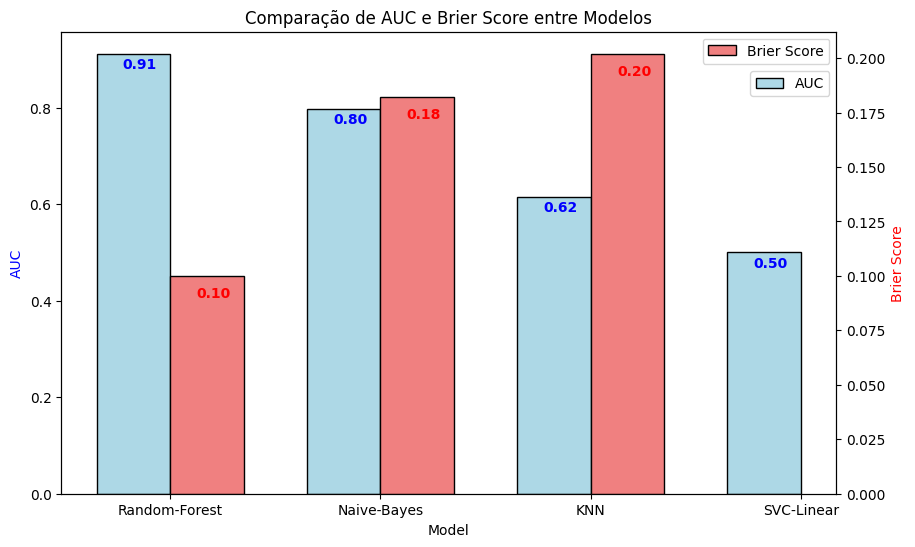

In [41]:
fig, ax1 = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(models))

# Gráfico de AUC sem hachuras nas barras
bar1 = ax1.bar(index, auc_scores, bar_width, label='AUC', color='lightblue', edgecolor='black')

# Criando segundo eixo para o Brier Score sem hachuras
ax2 = ax1.twinx()
bar2 = ax2.bar(index + bar_width, brier_scores, bar_width, label='Brier Score', color='lightcoral', edgecolor='black')

# Adicionando labels e título
ax1.set_xlabel('Model')
ax1.set_ylabel('AUC', color='blue')
ax2.set_ylabel('Brier Score', color='red')
plt.title('Comparação de AUC e Brier Score entre Modelos')

# Configurando os ticks
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(models)

# Adicionando os valores em cima das barras
for i, v in enumerate(auc_scores):
    ax1.text(i - 0.05, v - 0.03, f'{v:.2f}', color='blue', fontweight='bold')

for i, v in enumerate(brier_scores):
    if not np.isnan(v):
        ax2.text(i + bar_width - 0.05, v - 0.01, f'{v:.2f}', color='red', fontweight='bold')

# Legendas ajustadas
ax2.legend(loc='upper right')
ax1.legend(loc='upper right', bbox_to_anchor=(1, .93))


plt.savefig('plots//roc_auc_and_brier_score.png')

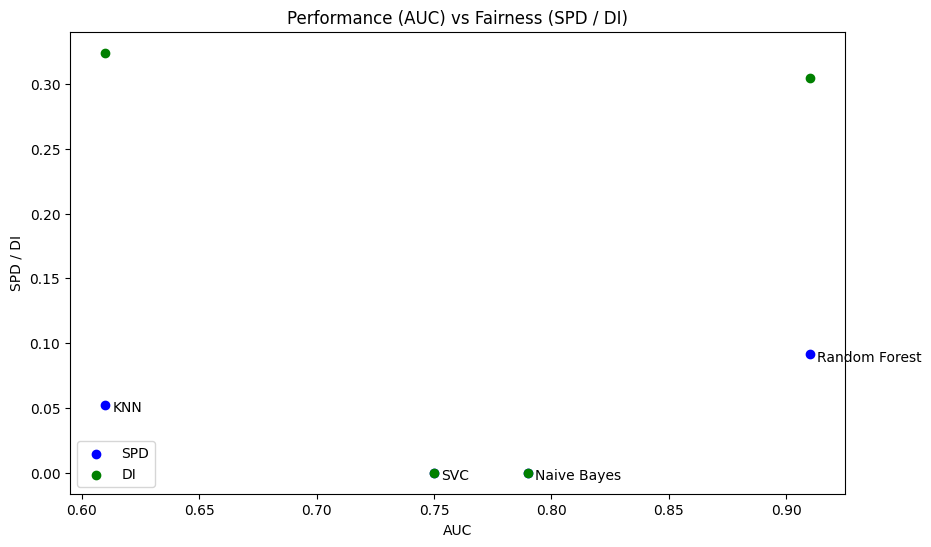

In [1]:
import matplotlib.pyplot as plt

# Exemplo de dados hipotéticos
models = ['Random Forest', 'Naive Bayes', 'KNN', 'SVC']
auc_scores = [0.91, 0.79, 0.61, 0.75]
spd_scores = [0.0915, 0.0, 0.0524, 0.0]
di_scores = [0.3047, 0.0, 0.3241, 0.0]

# Scatter plot AUC vs SPD
plt.figure(figsize=(10,6))
plt.scatter(auc_scores, spd_scores, color='blue', label='SPD')
plt.scatter(auc_scores, di_scores, color='green', label='DI')
for i, txt in enumerate(models):
    plt.annotate(txt, (auc_scores[i], spd_scores[i]), xytext=(5,-5), textcoords='offset points')
plt.xlabel('AUC')
plt.ylabel('SPD / DI')
plt.title('Performance (AUC) vs Fairness (SPD / DI)')
plt.legend()
plt.show()

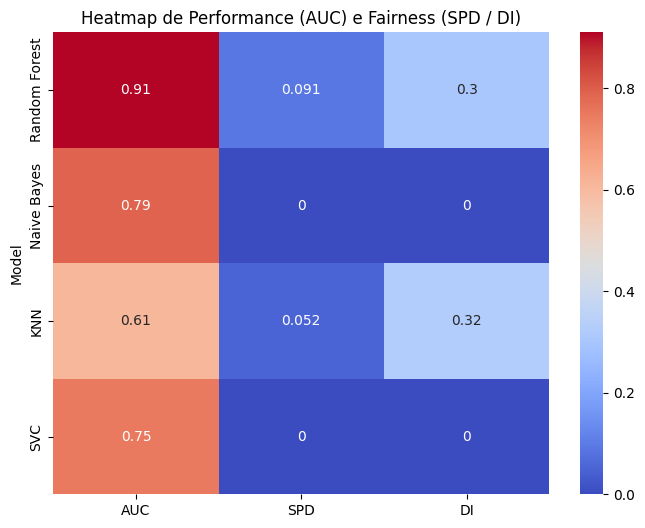

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Dados hipotéticos
data = {
    'Model': ['Random Forest', 'Naive Bayes', 'KNN', 'SVC'],
    'AUC': [0.91, 0.79, 0.61, 0.75],
    'SPD': [0.0915, 0.0, 0.0524, 0.0],
    'DI': [0.3047, 0.0, 0.3241, 0.0]
}

df = pd.DataFrame(data)
df.set_index('Model', inplace=True)

plt.figure(figsize=(8,6))
sns.heatmap(df, annot=True, cmap='coolwarm', cbar=True)
plt.title('Heatmap de Performance (AUC) e Fairness (SPD / DI)')
plt.show()


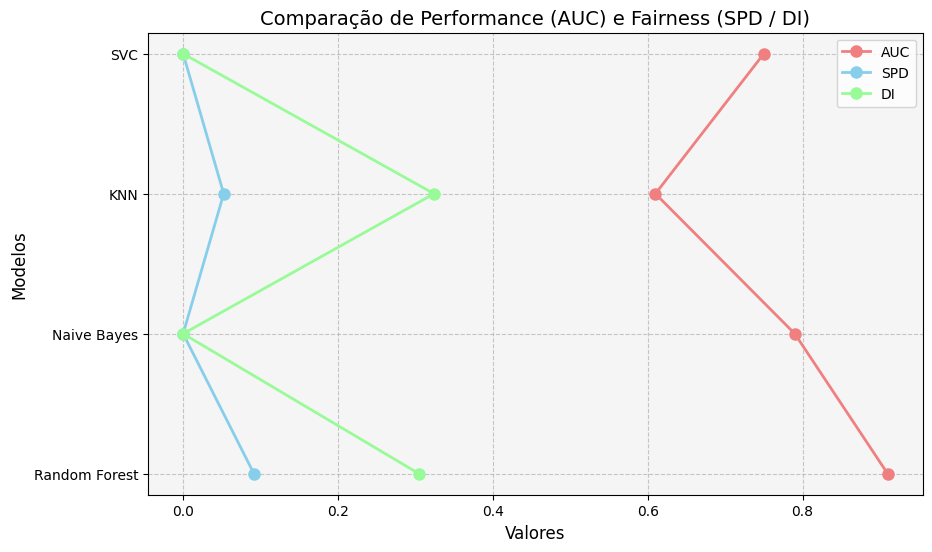

In [4]:
# Inverter o gráfico para que os modelos estejam no eixo Y e os valores no eixo X

plt.figure(figsize=(10, 6))

# Plotando AUC com uma linha suave
plt.plot(auc_scores, models, label='AUC', marker='o', color='lightcoral', linestyle='-', linewidth=2, markersize=8)

# Plotando SPD com uma linha suave
plt.plot(spd_scores, models, label='SPD', marker='o', color='skyblue', linestyle='-', linewidth=2, markersize=8)

# Plotando DI com uma linha suave
plt.plot(di_scores, models, label='DI', marker='o', color='palegreen', linestyle='-', linewidth=2, markersize=8)

# Personalizando o gráfico
plt.title('Comparação de Performance (AUC) e Fairness (SPD / DI)', fontsize=14)
plt.ylabel('Modelos', fontsize=12)
plt.xlabel('Valores', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Usando tons pastéis para o fundo
plt.gca().set_facecolor('whitesmoke')

# Exibir o gráfico
plt.show()
